# Assessing quality of CO functionalized tips

In [3]:
import os
import glob
import numpy as np
from PIL import Image
from scipy import misc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import cm
%matplotlib inline


## Upload AFM data with bad and good samples of CO-tips
Download AFM-data with CO-tips samples from here: https://www.dropbox.com/s/gz9bvcd2cj5qidd/databaseNew3.tar.gz?dl=0. Extract the archive and set the path of the directory to the variable path_to_data below.

In [4]:
path_to_data = './databaseNew3'

## PCA *analysis* 

In [5]:
!ls PCA/

CO_tips_explained_variance.png		 explained_variance_raw.png
CO_tips_pca_no_rotations_cropsize32.png  pca_data_no_rotations_cropsize32.png
CO_tips_t-SNE_2D_n_iter_var.png		 tsne_raw_2D_n_iter_var.png
CO_tips_t-SNE_2D_perplexity_var.png	 tsne_raw_2D_perplexity_var.png
CO_tips_t-SNE_2D.png			 tsne_raw_2D.png
CO_tips_t-SNE_3D.png			 tsne_raw_3D.png
dataset_pca.npz


In [6]:
# Here we generate dataset for PCA and t-SNE analysis. All available images without augumentation are used (enable_rotations = False).

save_dir         = './PCA/'
classes          = ['bads', 'goods']
crop_size        = 32    # different size images would be transformed to size 32 x 32
enable_rotations = False # no augumentation by rotations for PCA analysis
if os.path.exists(save_dir+'dataset_pca.npz'): 
    # if dataset was generated before, just load it
    print ('dataset founded')
    try:    
        data= np.load(save_dir+'dataset_pca.npz')
        trainX=data['trainX']
        trainY=data['trainY']
        valX=data['valX']
        valY=data['valY']
        testX=data['testX']
        testY=data['testY']
        print (f'trainY: {len(trainY)}')    
        print (f'valY: {len(valY)}')    
        print (f'testY: {len(testY)}')    
        print ('dataset loaded succesfully')
    except KeyError as e:
        print('Could not find filename %s' % e)
else:  
    #no dataset founded, we generate new one and save it
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # train data
    print('gen training data') 
    trainX, trainY = generate_data_from_images(path_to_data, 'train', classes,crop_size, enable_rotations)
    print (f'trainX: {trainX.shape}')
    print (f'trainY: {trainY.shape}')

    # validation data
    print('gen validation data')  
    valX, valY     = generate_data_from_images(path_to_data, 'valid', classes,crop_size, enable_rotations)
    print (f'valX: {valX.shape}')
    print (f'valY: {valY.shape}')

    # test data
    print('gen test data')  
    testX, testY   = generate_data_from_images(path_to_data, 'test2', classes,crop_size, enable_rotations) 
    print (f'testX: {testX.shape}')
    print (f'testY: {testY.shape}')
    
    # save whole PCA dataset
    file_dataset = 'dataset_pca.npz'
    np.savez(save_dir+ file_dataset , trainX=trainX,trainY=trainY, valX = valX, valY = valY, testX =testX, testY =testY  )
    print (f'dataset saved succesfully to {save_dir+ file_dataset}')


dataset founded
trainY: 211
valY: 74
testY: 154
dataset loaded succesfully


In [7]:
from sklearn.preprocessing import MinMaxScaler

save_dir = './PCA/'
# Do Principal component analysis
pca_data_X = trainX
pca_data_X = pca_data_X.reshape((pca_data_X.shape[0],-1)) # reszie each image 1x32x32 --> 1x1024

#scaler = MinMaxScaler()
#pca_data_X = scaler.fit_transform(pca_data_X)
print('Augmented data shape:', pca_data_X.shape)

pca = PCA()
T = pca.fit_transform(pca_data_X)
print(f'explained_variance_ratio: {pca.explained_variance_ratio_[:5]}')
print(f'explained_variance_ratio sum: {pca.explained_variance_ratio_[:5].cumsum()}') 
print(f'X_reduced: {T.shape}')
print(f'trainY: {trainY.shape}')


Augmented data shape: (211, 1024)
explained_variance_ratio: [0.7869874  0.06543522 0.04983685 0.02561842 0.01272073]
explained_variance_ratio sum: [0.7869874  0.85242265 0.9022595  0.92787796 0.9405987 ]
X_reduced: (211, 211)
trainY: (211,)


[0.7869874  0.06543522 0.04983685 0.02561842 0.01272073 0.00816186
 0.00610408 0.00509518 0.00429871 0.00360892]


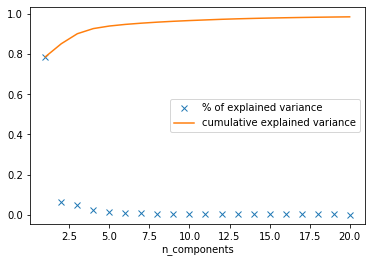

In [8]:
# Plot explained variance as a function of number of components

print(pca.explained_variance_ratio_[:10])
plt.figure()
n_comp = 20
plt.plot(range(1,n_comp+1), pca.explained_variance_ratio_[:n_comp], 'x')
plt.plot(range(1,n_comp+1),np.cumsum(pca.explained_variance_ratio_[:n_comp]))
plt.xlabel('n_components')
plt.legend(['% of explained variance', 'cumulative explained variance'])
plt.savefig(save_dir + 'CO_tips_explained_variance.png', bbox_inches='tight', dpi=200)

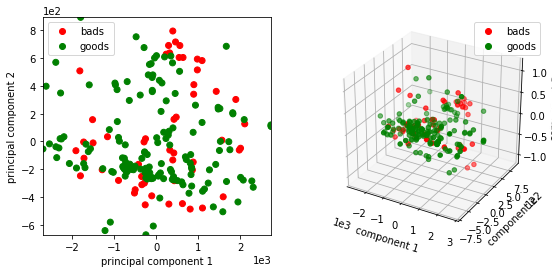

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

classes          = ['bads', 'goods']
colours = ListedColormap(['r','g'])

# Visualize with two principle components
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(121)
scatter = plt.scatter(T[:,0], T[:,1], c=trainY.ravel(), cmap=colours )
plt.xlim(T[:,0].min(), T[:,0].max())
plt.ylim(T[:,1].min(), T[:,1].max())
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

# Visualize with three principle components
ax = fig.add_subplot(122, projection='3d')
scatter = ax.scatter(T[:,0], T[:,1], T[:,2], c=trainY.ravel(), cmap=colours)
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
ax.set_zlabel('component 3')
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()
save_name = f'CO_tips_pca_no_rotations_cropsize{crop_size}.png'
fig.savefig(save_dir+save_name, bbox_inches='tight', dpi=200)
plt.close()

## t-SNE  [t-distributed stochastic neighbor embedding] 
Visualizing data using t-SNE, L.v.d. Maaten, G. Hinton, Journal of Machine Learning Research, Vol 9(Nov), pp. 2579—2605. 2008.
https://distill.pub/2016/misread-tsne/

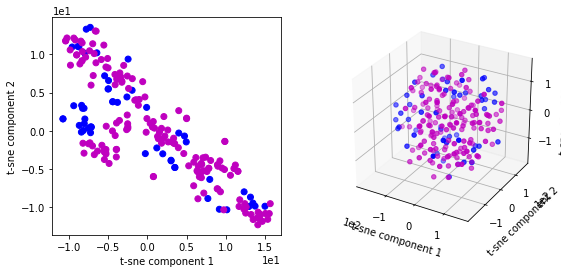

In [43]:
np.random.seed(0)

# t-SNE 2 components analysis
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
E2 = tsne.fit_transform(pca_data_X)

# t-SNE 3 components
tsne = TSNE(n_components=3, perplexity=30, learning_rate=200)
E3 = tsne.fit_transform(T[:,:50])
 
# Visualize t-sne embedding: 2 components   
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(121)    
colours2 = ListedColormap(['b','m'])
plt.scatter(E2[:,0], E2[:,1], c=trainY.ravel(), cmap=colours2)
#plt.legend(handles=scatter.legend_elements()[0], labels=classes)

plt.xlabel('t-sne component 1')
plt.ylabel('t-sne component 2')
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

# Visualize t-sne embedding: 3 components   
ax = fig.add_subplot(122, projection='3d')
ax.scatter(E3[:,0], E3[:,1], E3[:,2], c=trainY.ravel(), cmap=colours2)
#plt.legend(handles=scatter.legend_elements()[0], labels=classes)

ax.set_xlabel('t-sne component 1')
ax.set_ylabel('t-sne component 2')
ax.set_zlabel('t-sne component 3')
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

plt.savefig(save_dir+'CO_tips_t-SNE_no_rotations_cropsize{crop_size}.png', bbox_inches='tight', dpi=200)
plt.close()


perplexity  2
perplexity  5
perplexity  10
perplexity  30
perplexity  100
perplexity  500


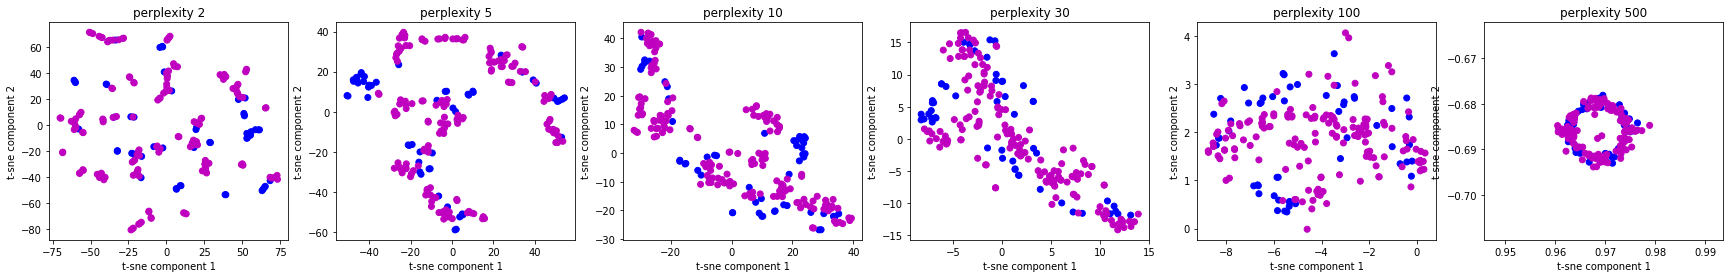

<Figure size 432x288 with 0 Axes>

In [42]:
# Let's vary parameters for t-SNE 
# here perplexities parameter varied. “perplexity,” says (loosely) 
# how to balance attention between local and global aspects of your data. 
# “The performance of SNE is fairly robust to changes in the perplexity, and typical values are between 5 and 50.”
perplexities = [2 , 5, 10 , 30, 100, 500]   #range 2 to N

E2_perpl = []
for perplexity in perplexities:
    print ('perplexity ', perplexity)
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=200)
    E2_perpl.append(tsne.fit_transform(pca_data_X))   


plt.figure(figsize=(5*len(perplexities),4))
for i, d in enumerate(E2_perpl):
    plt.subplot(101+len(perplexities)*10+i)
    colours2 = ListedColormap(['b','m'])
    plt.scatter(d[:,0], d[:,1], c=trainY.ravel(), cmap=colours2)
    plt.xlabel('t-sne component 1')
    plt.ylabel('t-sne component 2')
    ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
    #plt.legend(handles=scatter.legend_elements()[0], labels=classes)
    plt.title('perplexity '+str(perplexities[i]))
plt.show()


plt.savefig(save_dir+'CO_tips_t-SNE_2D_perplexity_var.png', dpi=200, bbox_inches='tight')
plt.close()

n_iter  250
n_iter  300
n_iter  350
n_iter  500
n_iter  1000


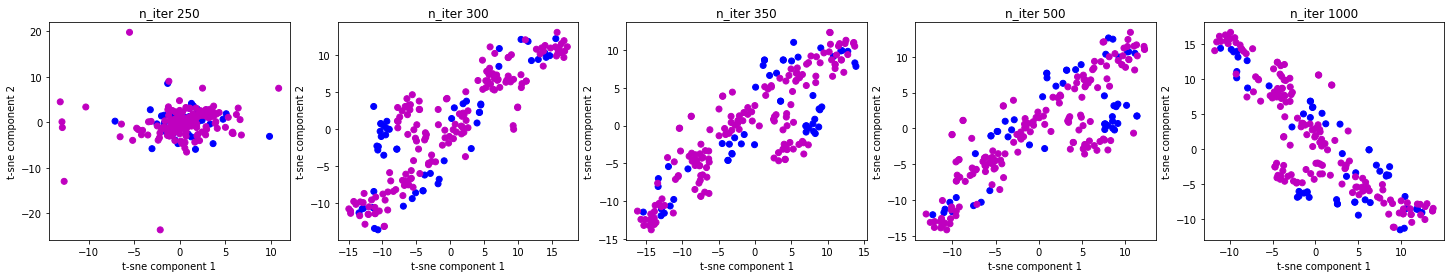

<Figure size 432x288 with 0 Axes>

In [41]:
# here n_iterations is varied

iterations   = [250, 300, 350, 500, 1000] 

E2 = []
for iteration in iterations:
    print ('n_iter ', iteration)
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter = iteration)
    E2.append(tsne.fit_transform(pca_data_X))   

plt.figure(figsize=(5*len(iterations),4))
for i, d in enumerate(E2):
    plt.subplot(101+len(iterations)*10+i)
    colours2 = ListedColormap(['b','m'])
    plt.scatter(d[:,0], d[:,1], c=trainY.ravel(), cmap=colours2)
    plt.xlabel('t-sne component 1')
    plt.ylabel('t-sne component 2')
    ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
    #plt.legend(handles=scatter.legend_elements()[0], labels=classes)
    plt.title('n_iter '+str(iterations[i]))
plt.show()


plt.savefig(save_dir+'CO_tips_t-SNE_2D_n_iter_var.png', dpi=200, bbox_inches='tight')
plt.close()

## CNN analysis

In [3]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module, Sequential, Conv2d, ReLU,LeakyReLU
import sys
from sklearn.metrics import confusion_matrix
from utils import *
import os
torch.manual_seed(1)
np.random.seed(0)

In [7]:
# CNN training parameters
descriptors    = ['class']
classes        = ['bads', 'goods']
batch_size     = 32
epochs         = 19
pred_batches = 10 
verbose = 1
crop_size        = 32
enable_rotations = True
 
save_dir         = './CNN/'
model_dir = save_dir
batch_dir = model_dir+'batch_imgs/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


if os.path.exists(save_dir+'dataset_cnn.npz'):
    print ('dataset cnn founded')
    try:    
        data= np.load(save_dir+'dataset_cnn.npz')
        trainX=data['trainX']
        trainY=data['trainY']
        valX=data['valX']
        valY=data['valY']
        testX=data['testX']
        testY=data['testY']
        print (f'trainY: {len(trainY)}')    
        print (f'valY: {len(valY)}')    
        print (f'testY: {len(testY)}')    
        print ('dataset loaded succesfully')
    except KeyError as e:
        print('Could not find filename %s' % e)
else:

 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # train
    print('gen training data') 
    trainX, trainY = generate_data_from_images(path_to_data, 'train', classes,crop_size, enable_rotations)
    print (f'trainX: {trainX.shape}')
    print (f'trainY: {trainY.shape}')

    # validation
    print('gen validation data')  
    valX, valY     = generate_data_from_images(path_to_data, 'valid', classes,crop_size, enable_rotations)
    print (f'valX: {valX.shape}')
    print (f'valY: {valY.shape}')

    # test  generate test data without augumentations
    print('gen test data')  
    testX, testY   = generate_data_from_images(path_to_data, 'test2', classes,crop_size, enable_rotations=False) 
    print (f'testX: {testX.shape}')
    print (f'testY: {testY.shape}')
    file_dataset = 'dataset_cnn.npz'
    np.savez(save_dir+ file_dataset , trainX=trainX,trainY=trainY, valX = valX, valY = valY, testX =testX, testY =testY  )
    print (f'dataset cnn saved succesfully to {save_dir+ file_dataset}')
train_len = trainY.shape[0]//batch_size
val_len = valY.shape[0]//batch_size
test_len = testY.shape[0]//batch_size
print ('Total amount of samples: ', trainY.shape[0] +valY.shape[0] + testY.shape[0])

dataset cnn founded
trainY: 844
valY: 296
testY: 154
dataset loaded succesfully
Total amount of samples:  1294


In [1]:
from models import *

def criterion(outputs,Y):
    #nn.BCEWithLogitsLoss()
    return F.nll_loss(outputs,Y)

model = conv_net1()
model.cuda()
optimizer = optim.Adam(model.parameters())
#loss_function = nn.BCEWithLogitsLoss()


In [2]:
from torchsummary import summary
summary(model, (1,32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 30, 30]              40
         LeakyReLU-2            [-1, 4, 30, 30]               0
         Dropout2d-3            [-1, 4, 30, 30]               0
            Conv2d-4            [-1, 8, 28, 28]             296
         LeakyReLU-5            [-1, 8, 28, 28]               0
         Dropout2d-6            [-1, 8, 28, 28]               0
            Conv2d-7           [-1, 16, 12, 12]           1,168
         LeakyReLU-8           [-1, 16, 12, 12]               0
         Dropout2d-9           [-1, 16, 12, 12]               0
           Conv2d-10             [-1, 32, 4, 4]           4,640
        LeakyReLU-11             [-1, 32, 4, 4]               0
        Dropout2d-12             [-1, 32, 4, 4]               0
           Conv2d-13             [-1, 64, 1, 1]           8,256
        LeakyReLU-14             [-1, 6

In [5]:
# model check 
#x = np.random.rand(16,4,128,128)
#x_t = torch.from_numpy(x).float().cuda() 
#outputs = model(x_t)

### Training and validation processes

In [8]:
print('\n === Starting training loop \n')
start_time = time.time()
# Initialize loss log
loss_log = LossAccuLog(model_dir, descriptors=descriptors)

# Create a folder for model checkpoints
checkpoint_dir = model_dir+'CheckPoints/'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Create a folder for model predictions
pred_dir = model_dir+'predictions/'
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

    
    
for epoch in range(epochs):

    # generating cropped augumented data

    if verbose > 0: print('\nEpoch '+str(epoch+1))

    # Try to load model checkpoint
    if os.path.exists(checkpoint_dir+'model_'+str(epoch+1)+'.pth'):
        model.load_state_dict(torch.load(checkpoint_dir+'model_'+str(epoch+1)+'.pth'))
        model.eval()
        print('Model loaded from '+checkpoint_dir+'model_'+str(epoch+1)+'.pt')
    else:

        train_loss = np.zeros(1)
        val_loss = np.zeros(1)
        train_accu = np.zeros(1)
        val_accu = np.zeros(1)
        epoch_start = time.time()
        # Train
        
        model.train()            
        preds_train = np.zeros(train_len*batch_size)
        for batch in range(train_len):
            #scheduler.step()
            batch_indexes = np.arange(batch*batch_size,(batch+1)*batch_size)
            
            X = trainX[batch_indexes]
            Y = trainY[batch_indexes] 
            add_norm_CO(X)

            #print (f'Y = {Y}')
            #print (f'Y.shape = {Y.shape}')
            X = torch.from_numpy(X).float().cuda()
            X.unsqueeze_(1)
            Y = torch.from_numpy(Y).long().cuda()
            #print (f'Y = {Y}')

            # Train model
            #print('%f (Fit) Training on batch' % time.time())

            # zero the parameter gradients
            optimizer.zero_grad()


            # forward + backward + optimize
            outputs = model(X)
            if (batch < 2) and ((epoch+1) % 2 ==0):
                make_batch_plots(X,Y,outputs.exp().detach(),epoch+1, batch+1,'train',classes, outdir=model_dir)
                
            #print('Model finished')
            
            loss =  criterion(outputs,Y)
            _, predicted = torch.max(outputs.data,1)
            preds_train[batch_indexes] = predicted.cpu()
            #print (f'predicted = {predicted}')                
            total = Y.size(0)
            correct = (predicted == Y).sum().item() 
            accuracy = 100. * correct / total   
            #loss = cross_entropy_one_hot(outputs,Y)
            #print('Loss calculated')
            #print (f'loss item = {loss.item()}')
            loss.backward()
            #print('Loss backwarded')
            optimizer.step()
            #print('optimizer stepped')
            # print statistics

            # Update mean loss
            # print('%f (Fit) Updating loss' % time.time())
            train_loss = train_loss + (loss.item() - train_loss) / (batch+1)        

            # Update mean accuracy
            # print('%f (Fit) Updating accuracy % time.time())
            train_accu = train_accu + (accuracy - train_accu) / (batch+1)        


            # Print information
#                print('%f (Fit) Printing information' % time.time())
            if (batch+1 == train_len):
                
                eta = (time.time() - epoch_start) / (batch+1) * ((train_len+val_len) - (batch + 1))
                msg = 'Epoch '+str(epoch+1)+', Batch '+str(batch+1)
                for i in range(len(train_loss)):
                    msg +=  ' - Loss '+': %.4g'% train_loss[i]
                    msg +=  ' - Accuracy '+': %.4g'% train_accu[i]
                msg += ' - ETA: %ds' % eta
                print(msg)
                print (f'loss item = {loss.item()}')
                #print (f'outputs = {outputs}')
        #print('Reset scheduler')
        #scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)                
            # Task done on queue item
#                print('%f (Fit) Task done' % time.time())



        # Validate
        if verbose > 0: print('Validation')
        model.eval() 
        with torch.no_grad():
            preds_val = np.zeros(val_len*batch_size)
            for batch in range(val_len):
            #for batch in range(20): 
                batch_indexes = np.arange(batch*batch_size,(batch+1)*batch_size)
            
                # Get new batch from queue when available
                X = valX[batch_indexes]
                Y = valY[batch_indexes]
                #print (f'X.shape = {X.shape}')
                #print (f'Y.shape = {Y.shape}')
                #for i in range(X.shape[0]):
                #    X[i,2,:,:] = np.clip(X[i,2,:,:], None, adhesive_treshold*np.max(X[i,2,:,:]))
                #X = X [:,2,:,:]
                #X = np.expand_dims(X, axis=1)             
                add_norm_CO(X)
                #X = np.clip(X, None, adhesive_treshold)
                #X = X * weight
                X = torch.from_numpy(X).float().cuda()
                X.unsqueeze_(1)
                Y = torch.from_numpy(Y).long().cuda()
                # Calculate loss on batch

                outputs = model(X)

                if (batch < 2) and ((epoch +1)% 2 ==0):
                    make_batch_plots(X,Y,outputs.exp().detach(),epoch+1, batch+1,'valid', classes, outdir=model_dir)
                    
                #loss =  cross_entropy_one_hot(outputs,Y)
                loss =  criterion(outputs,Y)
                #print (f'outputs = {outputs}')
                _, predicted = torch.max(outputs.data,1)
                preds_val[batch_indexes] = predicted.cpu()
                #print (f'predicted = {predicted}')                
                total = Y.size(0)
                correct = (predicted == Y).sum().item()    
                accuracy = 100. * correct / total   
                # Update mean loss
                val_loss += (loss.item() - val_loss) / (batch+1)
                val_accu += (accuracy - val_accu) / (batch+1)
                # Print information
                if verbose > 0:
                    eta = (time.time() - epoch_start) / (train_len+batch+1) * (val_len - (batch + 1))
                    #print('ETA: %ds' % eta)
                

            if verbose > 0:
                msg = 'Validation'
                for i in range(len(val_loss)):
                    msg +=  ' - Loss '+': %.4g'%val_loss[i]
                    msg +=  ' - Accuracy '+': %.4g'%val_accu[i]
                print(msg)
            
            if verbose > 0:
                time_diff = time.time() - epoch_start
                print('Epoch time: %ds' % time_diff + ' - Step time: %.4gs' % (time_diff/(train_len+val_len)))

            # Write loss history into log
            loss_log.add_loss(np.append(train_loss,val_loss))
            loss_log.add_accu(np.append(train_accu,val_accu))

                # Save model checkpoint
            # Save optimizer weights 
            torch.save(model.state_dict(), checkpoint_dir+'model_'+str(epoch+1)+'.pth')
            
            # Plot loss history
            loss_log.plot_history_loss()
            loss_log.plot_history_accu()

            # Plot confusion matrices
            conf_mat_train = confusion_matrix(trainY[:train_len*batch_size], preds_train)
            conf_mat_val = confusion_matrix(valY[:val_len*batch_size], preds_val)
            tick_labels = classes

            # Training set
            fig = plt.figure(figsize=(9.5,3.5))
            ax = fig.add_subplot(121)
            plot_confusion_matrix(ax, conf_mat_train, tick_labels)
            ax.set_title('Training set')

            # Validation set
            ax = fig.add_subplot(122)
            plot_confusion_matrix(ax, conf_mat_val, tick_labels)
            ax.set_title('Validation set')
            plt.savefig(model_dir+'predictions/'+'epoch'+str(epoch+1)+'_conf_mat_train_val.png', bbox_inches='tight', dpi=200)
            plt.close()

            # shuffle training and validatation data
            permut = np.random.permutation(trainX.shape[0])
            trainX, trainY = trainX[permut], trainY[permut]

            permut = np.random.permutation(valX.shape[0])
            valX, valY = valX[permut], valY[permut]

# Save final model
torch.save({'state_dict': model.state_dict()},  model_dir+'model.pth.tar')
 
print('\nModel saved to '+model_dir+'model.pth.tar')


 === Starting training loop 

Using existing log loss at ./CNN5/loss_log.csv
Using existing log accu at ./CNN5/accu_log.csv

Epoch 1
Model loaded from ./CNN5/CheckPoints/model_1.pt

Epoch 2
Model loaded from ./CNN5/CheckPoints/model_2.pt

Epoch 3
Model loaded from ./CNN5/CheckPoints/model_3.pt

Epoch 4
Model loaded from ./CNN5/CheckPoints/model_4.pt

Epoch 5
Model loaded from ./CNN5/CheckPoints/model_5.pt

Epoch 6
Model loaded from ./CNN5/CheckPoints/model_6.pt

Epoch 7
Model loaded from ./CNN5/CheckPoints/model_7.pt

Epoch 8
Model loaded from ./CNN5/CheckPoints/model_8.pt

Epoch 9
Model loaded from ./CNN5/CheckPoints/model_9.pt

Epoch 10
Model loaded from ./CNN5/CheckPoints/model_10.pt

Epoch 11
Model loaded from ./CNN5/CheckPoints/model_11.pt

Epoch 12
Model loaded from ./CNN5/CheckPoints/model_12.pt

Epoch 13
Model loaded from ./CNN5/CheckPoints/model_13.pt

Epoch 14
Model loaded from ./CNN5/CheckPoints/model_14.pt

Epoch 15
Model loaded from ./CNN5/CheckPoints/model_15.pt

Epoch 1

### Evaluation on a test set

In [9]:
accu_metrics = accuMetrics(n_classes=len(classes))
eval_loss = np.zeros(len(descriptors))
eval_start = time.time()
total = 0
correct = 0          
model.eval() 
#for batch in range(test_len):
preds_test = np.zeros(test_len*batch_size)
for batch in range(test_len):       
    print (f'test batch {batch}')
    batch_indexes = np.arange(batch*batch_size,(batch+1)*batch_size)
    
    # Get new batch from queue when available
    X = testX[batch_indexes]
    Y = testY[batch_indexes]
    
    #X = X [:,2,:,:]
    #X = np.expand_dims(X, axis=1)             
    #for i in range(X.shape[0]):
    #    X[i,2,:,:] = np.clip(X[i,2,:,:], None, adhesive_treshold*np.max(X[i,2,:,:]))
    add_norm_CO(X)
    #X = X * weight 
    X = torch.from_numpy(X).float().cuda()
    X.unsqueeze_(1)
    Y = torch.from_numpy(Y).long().cuda()
    # Calculate loss on batch



    # Test on batch
    outputs = model(X)
    loss = criterion(outputs,Y)
    loss = np.array(loss.item())
    eval_loss += (loss - eval_loss) / (batch+1)

    #accu_metrics.add_preds(outputs.exp().detach().cpu(), Y.cpu(), loss)
    #if batch == test_len - 1:
    #    accu_metrics.plot(outdir=model_dir)

    _, predicted = torch.max(outputs.data,1)
    preds_test[batch_indexes] = predicted.cpu()
    #print (f'predicted = {predicted}') 
    #print (f'Y = {Y}')                              
    total += Y.size(0)
    correct += (predicted == Y).sum().item()    
    
    
    


    if verbose > 0:
        eta = (time.time() - eval_start) / (batch+1) * (test_len - (batch + 1))
        print('ETA: %ds' % eta)
print(f'Accuracy on test set: {100 * correct / total}')
msg = 'Test set'
for i in range(len(eval_loss)):
    msg += ' - Loss '+descriptors[i]+': %.4g'%eval_loss[i]
print(msg)

with open(model_dir+'test_loss.txt','w') as f:
    for descriptor in descriptors:
        f.write(descriptor+';')
    for loss in eval_loss:
        f.write(str(loss)+';')

# Plot confusion matrices
conf_mat_test = confusion_matrix(testY[:test_len*batch_size], preds_test)
print (f'conf_mat_test = {conf_mat_test}')         
tick_labels = classes

fig = plt.figure(figsize=(4.7,3.5))
ax = fig.add_subplot(111)
plot_confusion_matrix(ax, conf_mat_test, tick_labels)
ax.set_title('Test set')
plt.savefig(model_dir+'predictions/'+'epoch'+str(epochs)+'_conf_mat_test_set.png', bbox_inches='tight', dpi=200)
plt.close() 


print('\n ======= Predict ')




if len(descriptors) > 1:
    descriptors = descriptors[1:]

counter = 0

for i in range(min(pred_batches, test_len)):
    batch_indexes = np.arange(i*batch_size,(i+1)*batch_size)
    X = testX[batch_indexes]
    true = testY[batch_indexes]

    #X = X [:,2,:,:]
    #X = np.expand_dims(X, axis=1)    
    #for i in range(X.shape[0]):
    #    X[i,2,:,:] = np.clip(X[i,2,:,:], None, adhesive_treshold*np.max(X[i,2,:,:]))
    add_norm_CO(X)
    #X = X * weight 
    X = torch.from_numpy(X).float().cuda()
    X.unsqueeze_(1)
    true = torch.from_numpy(true).long().cuda()

    #print (f'true[0].shape = {batch_data[1][0].shape}')
    #X, true = apply_preprocessing(batch_data)


    # Calculate loss on batch
    
    preds = model(X)

    #if (i < 2):
        #make_batch_plots(X,true,preds.exp().detach(),epochs, i,'test', outdir=model_dir)
    make_batch_plots(X,true,preds.exp().detach(),epochs, i+1,'test',classes, outdir=model_dir)
        
    loss =  criterion(preds,Y)
    losses = np.array(loss.item())
    #print (f'losses = {losses}')
    #print (f'preds = {preds}')
    #print (f'true = {true}')
    #X = X.cpu()
    #preds = preds.exp().detach().cpu()
    #true = true.cpu()

    #print (f'X.shape = {X.shape}')
    #print (f'preds.shape = {preds.shape}')
    #print (f'true.shape = {true.shape}')

    #np.save(pred_dir+'X_%d' % i, X )
    #np.save(pred_dir+'preds_%d' % i, preds )
    #np.save(pred_dir+'true_%d' % i, true )
    
        
    
    counter += len(X)

print('\nTraining loop finished in '+str(time.time()-start_time)+'s')

test batch 0
ETA: 0s
test batch 1
ETA: 0s
test batch 2
ETA: 0s
test batch 3
ETA: 0s
Accuracy on test set: 96.875
Test set - Loss class: 0.1126
conf_mat_test = [[113   4]
 [  0  11]]

 ======= Predict 
Input image saved to ./CNN5/predictions/epoch19_batch1_test.png
Input image saved to ./CNN5/predictions/epoch19_batch2_test.png
Input image saved to ./CNN5/predictions/epoch19_batch3_test.png
Input image saved to ./CNN5/predictions/epoch19_batch4_test.png

Training loop finished in 13.58957052230835s


In [0]:
%ls CNN_temp1

### Loss and accuracy at training

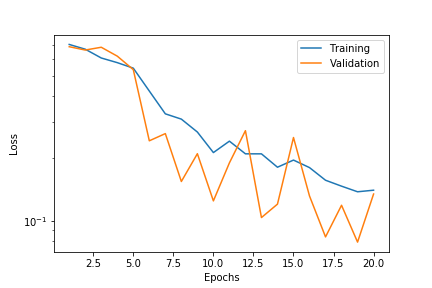

In [10]:
from IPython.display import Image
Image('CNN5/loss_history_class.png', height=300)

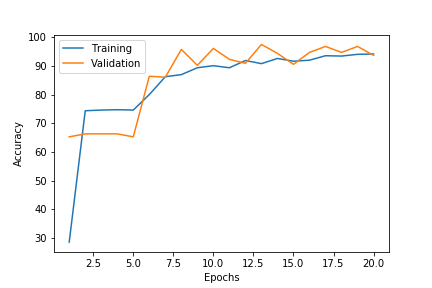

In [11]:
from IPython.display import Image
Image('CNN5/accu_history_class.png', height=300)

### Validation set: confusion matrix and prediction samples

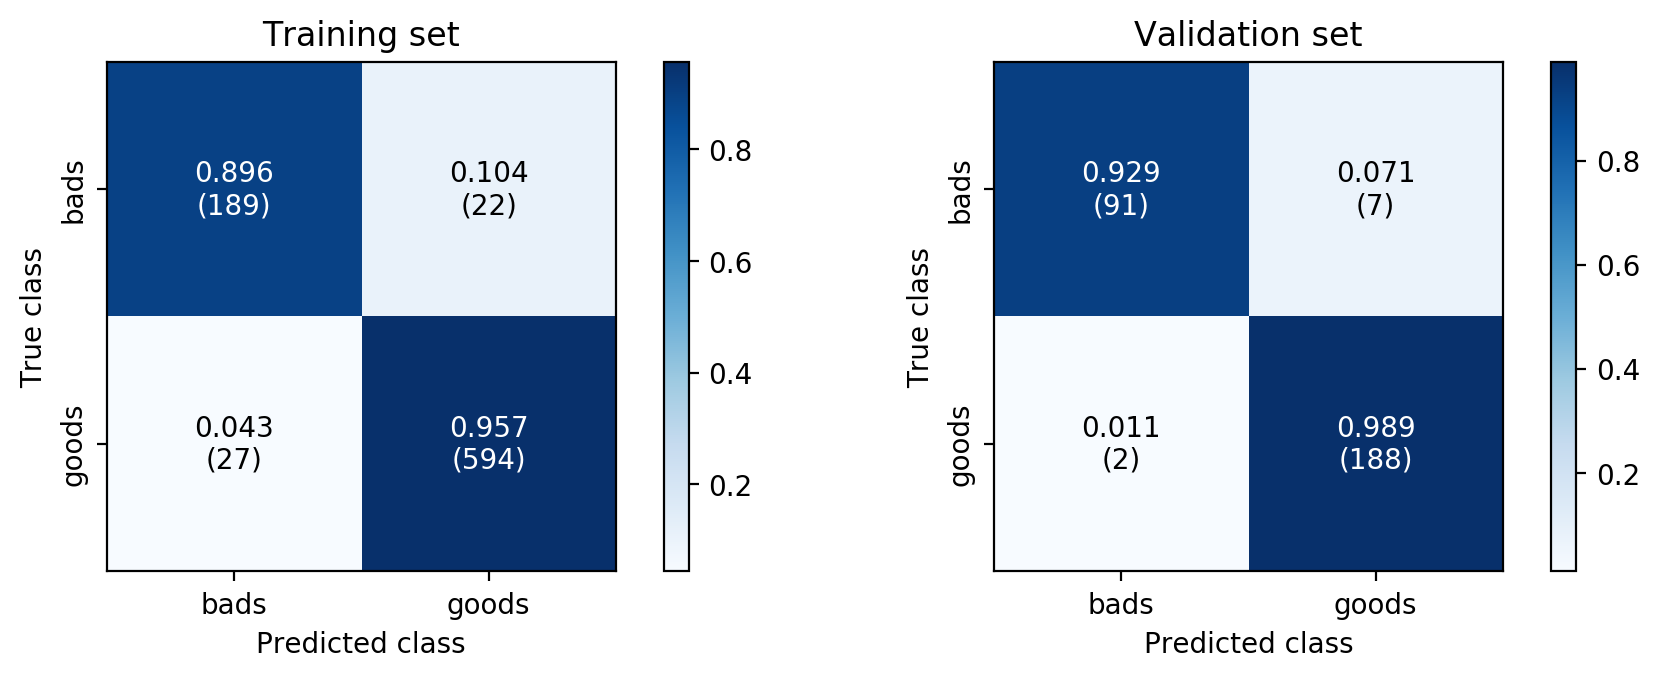

In [13]:
from IPython.display import Image
Image('CNN5/predictions/epoch19_conf_mat_train_val.png', height=300)

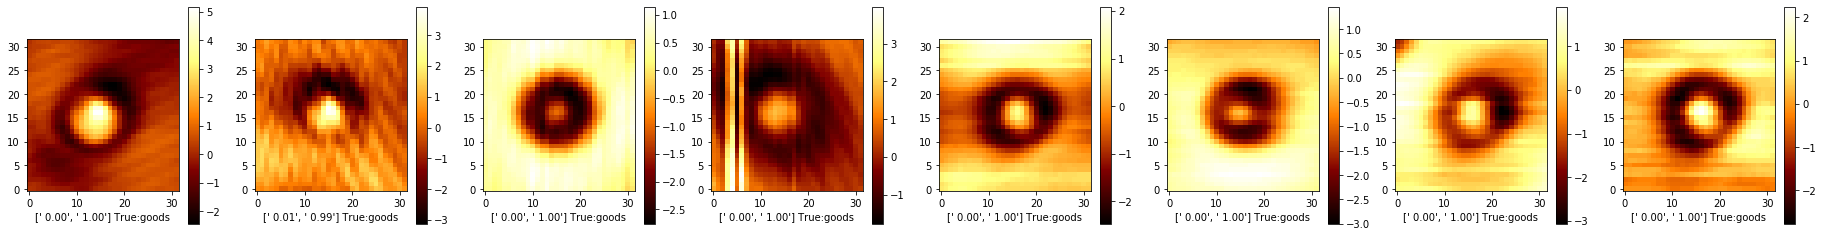

In [15]:
from IPython.display import Image
Image('CNN5/predictions/epoch18_batch1_valid.png')

### Test set: confusion matrix and prediction samples

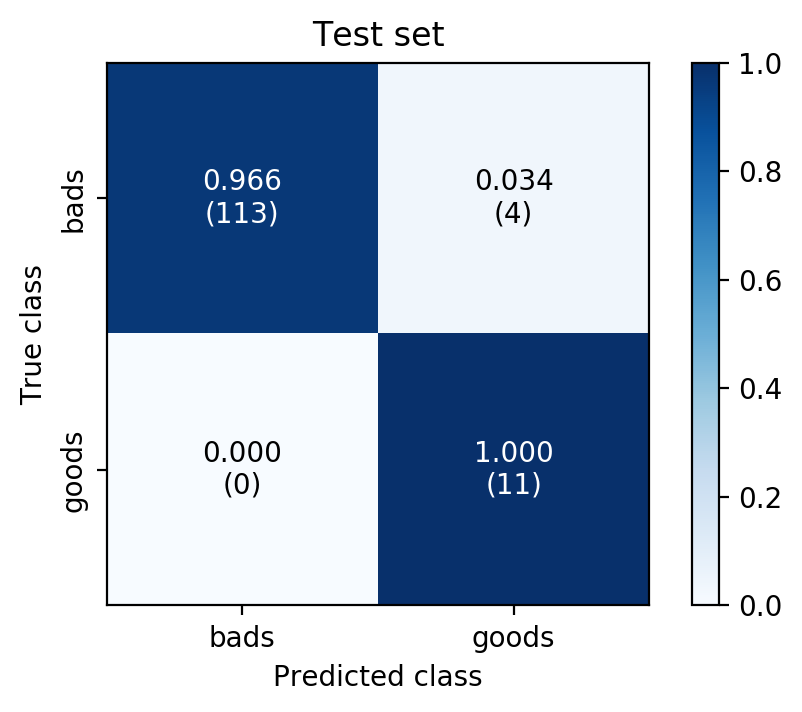

In [20]:
from IPython.display import Image
Image('CNN5/predictions/epoch19_conf_mat_test_set.png', height = 50)

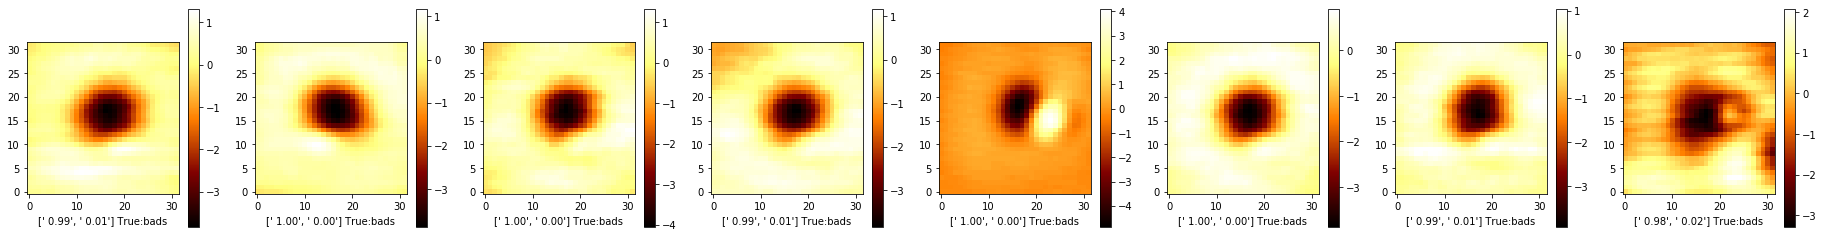

In [22]:
from IPython.display import Image
Image('CNN5/predictions/epoch19_batch1_test.png')

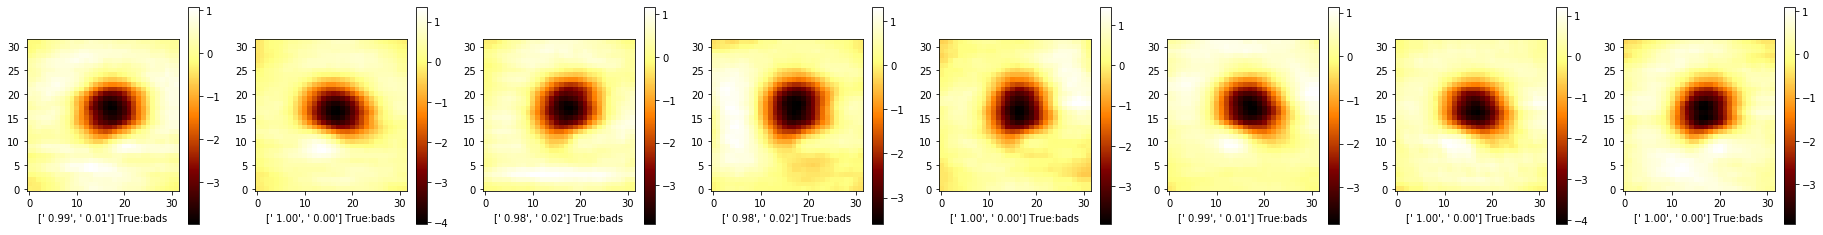

In [23]:
from IPython.display import Image
Image('CNN5/predictions/epoch19_batch2_test.png')

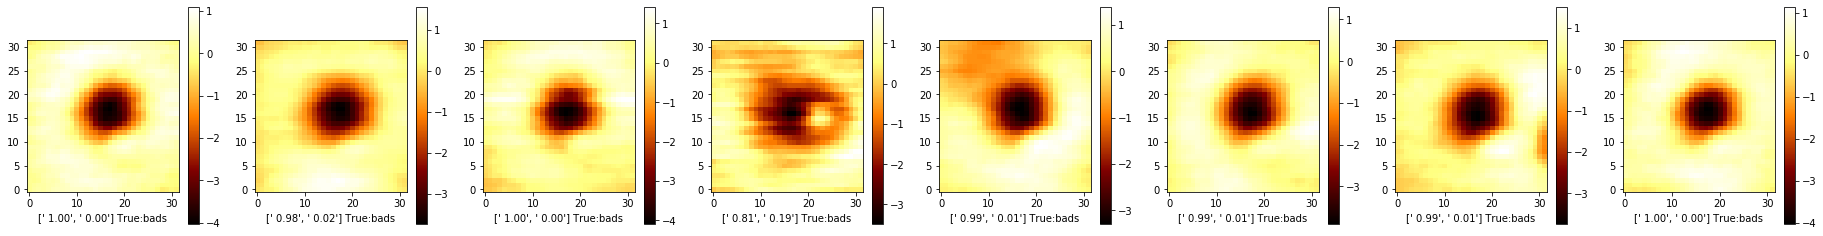

In [25]:
from IPython.display import Image
Image('CNN5/predictions/epoch19_batch3_test.png')

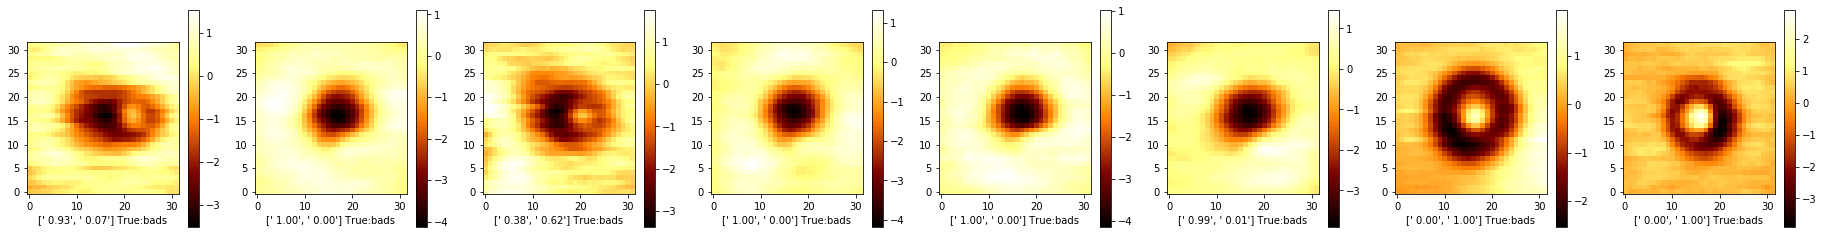

In [27]:
from IPython.display import Image
Image('CNN5/predictions/epoch19_batch4_test.png')